<a href="https://colab.research.google.com/github/kalilamali/Dermatology/blob/master/W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
% cd './drive/My Drive/'
% ls

[Errno 2] No such file or directory: './drive/My Drive/'
/content/drive/My Drive
 best_net.pth  'Colab Notebooks'/   dermatology/   skin/


In [142]:
!pip install torch

import random
import os
import numpy as np
import torch

def myseed(seed=42):
    """
    Make results reproducible.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
import os
import pandas as pd

from glob import glob

def load_data(data_dir='/content/drive/My Drive/skin'):
    """ 
    Find .jpg files and create a dataframe.
    """
    
    filenames = glob(os.path.join(data_dir, '*','*.jpg'))
    if len(filenames) == 0:
      filenames = glob(os.path.join(data_dir, '*', '*','*.jpg'))

    df = pd.DataFrame(data=filenames, columns=['filenames'])
    df['label'] = df['filenames'].str.extract(r'skin\W(\w+)\W')
    try:
      df['label'] = df['label'].astype('category')
      mapping = dict(enumerate(df['label'].cat.categories ))
    except AttributeError as err:
      mapping = ''
    df['label_code'] = pd.Categorical(df['label']).codes
    return df, mapping

In [0]:
from sklearn.model_selection import train_test_split
def data_split(df):
    """ 
    Split images in data_dir into
    train, val, test
    80,20,20
    """
    seed = 42
    train_val, test = train_test_split(df, test_size=0.2, random_state=seed)
    train_val, test = train_val.reset_index(drop=True), test.reset_index(drop=True)
    train, val = train_test_split(train_val, test_size=0.2, random_state=seed)
    train, val = train.reset_index(drop=True), val.reset_index(drop=True)
    return train, val, test

In [0]:
import torchvision
from torch.utils.data import DataLoader,Dataset
from PIL import Image

from torchvision import transforms

def get_loaders(size=100, batch_size=1, num_workers=1):
    """
    Put data into the dataloaders.
    """
    # Custom Pytorch dataloader for this dataset
    class Derm(Dataset):
        """
        Read a pandas dataframe with
        images paths and labels
        """
        def __init__(self, df, transform=None):
            self.df = df
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, index):
            # Load image data and get label
            X = Image.open(self.df['filenames'][index]).convert('RGB')
            y = torch.tensor(int(self.df['label_code'][index]))
            
            if self.transform:
                X = self.transform(X)

            return X, y

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Transforms
    data_transforms = {x : transforms.Compose([transforms.Resize(size),
                                              transforms.CenterCrop((size,size)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)]) for x in ['train', 'val', 'test', 'unknown']}
      
    # Frames
    df = {'train': train, 'val': val, 'test': test, 'unknown': unknown}                                    
    # Sets
    image_datasets = {x: Derm(df[x], transform=data_transforms[x]) for x in ['train', 'val', 'test', 'unknown']}
    # Sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'unknown']}
    # Loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size, num_workers) for x in ['train', 'val', 'test', 'unknown']}
    return data_transforms, df, image_datasets, dataloaders, dataset_sizes

In [146]:
! pip install torch
! pip install efficientnet-pytorch

import torch

from efficientnet_pytorch import EfficientNet
'''
def mymodel(unfreeze=True, num_classes=2):
  """
  Unfreeze(True) all the model weights or freeze(False) the convolutional 
  layers only
  """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
  model = model.to(device)
  for param in model.parameters():
    param.requires_grad = unfreeze
  return net
'''

'\ndef mymodel(unfreeze=True, num_classes=2):\n  """\n  Unfreeze(True) all the model weights or freeze(False) the convolutional \n  layers only\n  """\n  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n  model = EfficientNet.from_pretrained(\'efficientnet-b0\', num_classes=num_classes)\n  model = model.to(device)\n  for param in model.parameters():\n    param.requires_grad = unfreeze\n  return net\n'

In [0]:
from torch import nn

def mymodel(unfreeze=True):
  """
  Unfreeze(True) all the model weights or freeze(False) the convolutional 
  layers only
  """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)
  class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = model
            self.fc1 = nn.Linear(10, 2)
            
        def forward(self, x):
            x = self.model(x)
            x = self.fc1(x)
            x = torch.nn.functional.softmax(x)
            return x

  net = Net()
  model = model.to(device)
  net = net.to(device)
  if unfreeze is True:
      for param in model.parameters():
        param.requires_grad = unfreeze 
      for param in net.parameters():
          param.requires_grad = unfreeze
  if unfreeze is False:
      for param in model.parameters():
        param.requires_grad = unfreeze 
  return net

In [0]:
def get_num_parameters(model):
  """
  Get the total number of parameters in a neural network.
  """
  total_params = sum(p.numel() for p in model.parameters())
  total_trainable_params = sum(
  p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, total_trainable_params

In [0]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    """
    Train and evaluate a model.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track all losses
    training_loss, validation_loss = [], []
    # Track all acc
    training_acc, validation_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # This is batch loss
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
              training_loss.append(epoch_loss)
              training_acc.append(epoch_acc)
            if phase == 'val':
              validation_loss.append(epoch_loss)
              validation_acc.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_loss, validation_loss, training_acc, validation_acc

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def curve(training_loss, validation_loss, training_acc, validation_acc):
    """
    Plot loss and accuracy curves.
    """
    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss',)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(epoch, training_acc, 'r', label='Training acc',)
    plt.plot(epoch, validation_acc, 'b', label='Validation acc',)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [0]:
def run_test():
    """
    Run a test set only once.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))


In [0]:
#def my_calculator(future_epochs=50):
#    mydict = {num_epochs: time_elapsed}
#    future_time = future_epochs*my_dict[num_epochs]
#    print('Training complete in {:.0f}m {:.0f}s'.format(future_time // 60, future_time % 60))
#
#my_calculator(future_epochs=100)  

In [0]:
def get_weight(train):
  """
  Assign weights to handle imbalance classes
  """
  counts = train.label_code.value_counts().to_list()
  summed = sum(counts)
  weight = [x / summed for x in counts]
  weight = torch.tensor(weight)
  weight = weight.to(device)
  return(weight)

Loaded pretrained weights for efficientnet-b0
4,020,380 total parameters.
4,020,380 training parameters.
Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.6901 Acc: 0.6011
val Loss: 0.6901 Acc: 0.5435

Epoch 1/19
----------
train Loss: 0.6869 Acc: 0.6011
val Loss: 0.6853 Acc: 0.6087

Epoch 2/19
----------
train Loss: 0.6773 Acc: 0.6667
val Loss: 0.6791 Acc: 0.6957

Epoch 3/19
----------
train Loss: 0.6734 Acc: 0.7104
val Loss: 0.6717 Acc: 0.8043

Epoch 4/19
----------
train Loss: 0.6662 Acc: 0.7650
val Loss: 0.6637 Acc: 0.8261

Epoch 5/19
----------
train Loss: 0.6590 Acc: 0.7869
val Loss: 0.6553 Acc: 0.8696

Epoch 6/19
----------
train Loss: 0.6490 Acc: 0.8415
val Loss: 0.6466 Acc: 0.9130

Epoch 7/19
----------
train Loss: 0.6477 Acc: 0.8033
val Loss: 0.6448 Acc: 0.9130

Epoch 8/19
----------
train Loss: 0.6451 Acc: 0.8306
val Loss: 0.6432 Acc: 0.9130

Epoch 9/19
----------
train Loss: 0.6427 Acc: 0.8579
val Loss: 0.6417 Acc: 0.9348

Epoch 10/19
----------
train Loss: 0.6429 Acc: 0.8798
val Loss: 0.6404 Acc: 0.9348

Epoch 11/19
----------
train Loss: 0.6407 Acc: 0.8798
val Loss: 0.6390 Acc: 0.9565

Epoch 12/19
----------
t

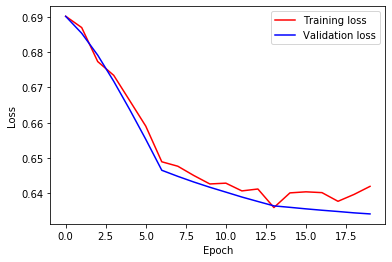

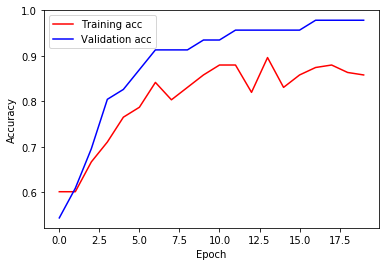

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the test images: 93 %
Training complete in 3m 12s


In [154]:
since = time.time()

myseed(seed=42)

# DATA
data, mapping = load_data(data_dir='/content/drive/My Drive/skin')
unknown, _= load_data(data_dir='/content/drive/My Drive/dermatology')
train, val, test = data_split(data)
data_transforms, df, image_datasets, dataloaders, dataset_sizes = get_loaders(size=224, batch_size=50,num_workers=4)

# MODEL
model = mymodel(unfreeze=True)
total_params, total_trainable_params = get_num_parameters(model) 
print(f'{total_params:,} total parameters.')
print(f'{total_trainable_params:,} training parameters.')

# PARAMS
import torch.optim as optim
from torch import nn
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight = get_weight(train)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# TRAIN
model, training_loss, validation_loss, training_acc, validation_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
curve(training_loss, validation_loss, training_acc, validation_acc)

# Save the trained model
PATH = './best_net.pth'
torch.save(model.state_dict(), PATH)
# Load our saved network
model.load_state_dict(torch.load(PATH))

#TEST
run_test()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [155]:
def make_predictions(mapping):
  """
  Use a model to predict a class
  Put the class in column predictions
  """
  with torch.no_grad():
    y_pred = []
    y_score = []
    for data in dataloaders['unknown']:
      images, labels = data
      images = images.to(device)
      outputs = model(images)
      scores, predicted = torch.max(outputs.data, 1)
      if len(predicted) == 1:
        y_pred.append(predicted.item())
        y_score.append(scores.item())
      else:
        y_pred.extend(np.squeeze(predicted.cpu().numpy().T))
        y_score.extend(np.squeeze(scores.cpu().numpy().T))
  unknown['score'] = y_score
  unknown['predictions'] = y_pred
  unknown['new_label'] = unknown['predictions'].map(mapping)
  return unknown

last_df = make_predictions(mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,new_label,predictions,score,image
0,not_skin,0,0.504221,
1,skin,1,0.554063,
2,skin,1,0.620283,
3,skin,1,0.608241,
4,skin,1,0.622253,
5,skin,1,0.601826,
6,skin,1,0.626788,
7,skin,1,0.525162,
8,not_skin,0,0.521222,
9,skin,1,0.597337,

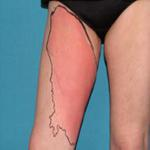
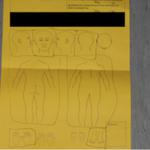
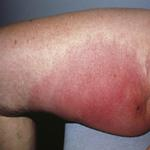
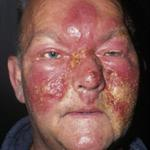
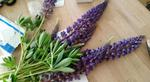
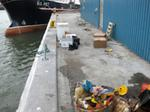
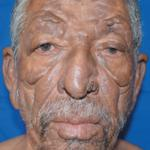
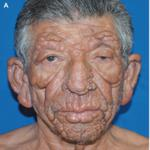
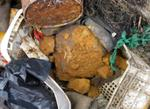
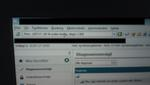
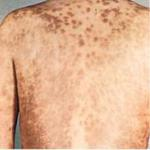

In [156]:
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

#pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path).convert('RGB')
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

last_df['image'] = last_df.filenames.map(lambda f: get_thumbnail(f))
#last_df.head()
#last_df.to_csv('/content/drive/My Drive/predictions.csv')
HTML(last_df[['new_label','predictions', 'score', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

In [0]:
# To print to log
#print('train', train.shape)
#print('test', test.shape)
#print('val', val.shape)
#print('unknown', unknown.shape)
#print(f'{total_params:,} total parameters.')
#print(f'{total_trainable_params:,} training parameters.')
#image, label = next(iter(dataloaders['train']))
#print(image.shape)
#print(label.shape)

In [158]:
# THE CONFUSION MATRIX IS ON THE TEST?

from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
y_score = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #print(outputs)
        scores, predicted = torch.max(outputs.data, 1)
        #print(scores)
        #print(predicted)
        #break
        if len(predicted) == 1:
          y_predict.append(predicted.item())
          y_true.append(labels.item())
          y_score.append(scores.item())
        else:
          y_pred.extend(np.squeeze(predicted.cpu().numpy().T))
          y_true.extend(labels.cpu().numpy())
          y_score.extend(np.squeeze(scores.cpu().numpy().T))

# compute the confusion matrix
confusion_matrix(y_true, y_pred, labels=[0, 1])

# MAP THE LIST TO SKIN NOT SKIN
# plot the confusion matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([[18,  3],
       [ 1, 36]])

In [159]:
# ROC TOO ON TEST?
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_score)

0.6936936936936937

In [160]:
# Generate a classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.92      0.97      0.95        37

    accuracy                           0.93        58
   macro avg       0.94      0.92      0.92        58
weighted avg       0.93      0.93      0.93        58

